# Part G(a): LQG Design for a Linear System

In [8]:
import numpy as np
import control as ctrl
import matplotlib.pyplot as plt

In [9]:
# 1. Define system parameters
M = 1000
mass_1 = 100
mass_2 = 100
length_1 = 20
length_2 = 10
g = 9.81

In [10]:
# Constructing state space matrices
A = np.array([[0, 1, 0, 0, 0, 0],
              [0, 0, -(mass_1*g)/M, 0, -(mass_2*g)/M, 0],
              [0, 0, 0, 1, 0, 0],
              [0, 0, -((M+mass_1)*g)/(M*length_1), 0, -(mass_2*g)/(M*length_1), 0],
              [0, 0, 0, 0, 0, 1],
              [0, 0, -(mass_1*g)/(M*length_2), 0, -(g*(M+mass_2))/(M*length_2), 0]])
B = np.array([[0], [1/M], [0], [1/(M*length_1)], [0], [1/(M*length_2)]])
D = np.zeros((1, 1))

In [11]:
# Define observer output matrices and corresponding L matrices
C_matrices = [np.array([[1, 0, 0, 0, 0, 0]]),  # Observing x component
              np.array([[1, 0, 0, 0, 0, 0], 
                        [0, 0, 0, 0, 1, 0]]), # Observing x and theta2
              np.array([[1, 0, 0, 0, 0, 0],     # Observing x, theta1 and theta2
                        [1, 0, 1, 0, 0, 0],
                        [0, 0, 0, 0, 1, 0]])]

In [12]:
# Defining LQR and Kalman filter parameters
Q = np.diag([100, 100, 100, 100, 100, 100])
R = np.array([[0.001]])
# Designing LQR controller
K, S, eigen_values = ctrl.lqr(A, B, Q, R)

# Defining noise covariance matrices for Kalman filter
v_d = 0.3 * np.eye(6)
v_n = 1

In [13]:
# Setting initial conditions for the observer
initial_conditions = np.array([4, 0, 30, 0, 60, 0, 0, 0, 0, 0, 0, 0])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


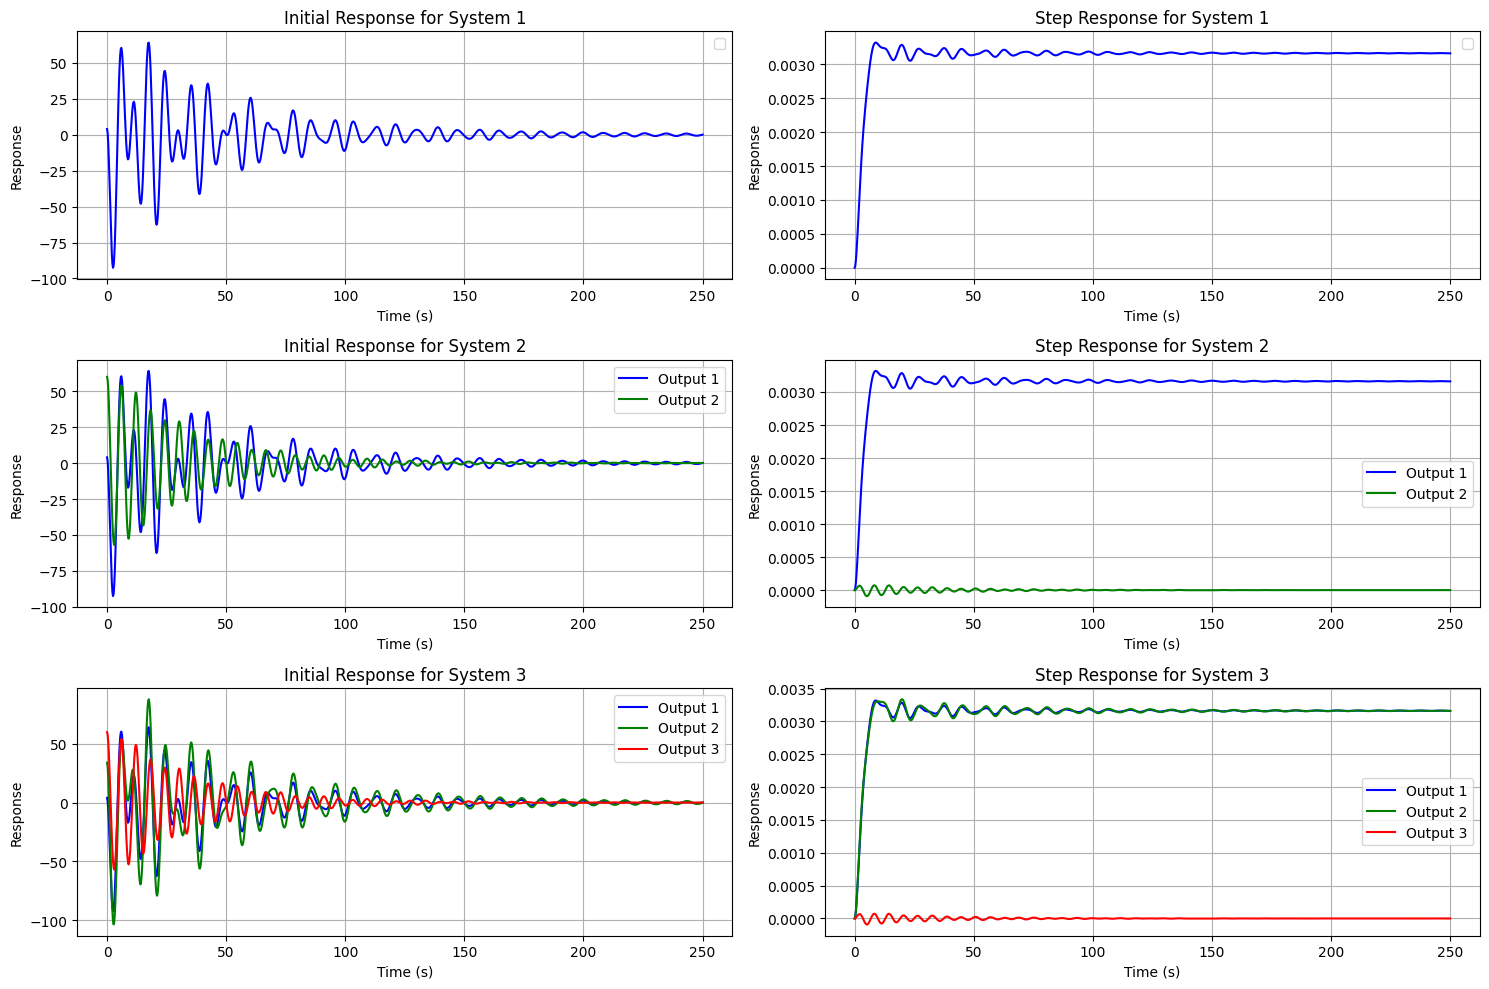

In [14]:
# Assign a color for each system
colors = ['b', 'g', 'r'] # Colors for plotting

# Creating figure for plots
plt.figure(figsize=(15, 10))

# Analyzing systems for each observable configuration
for i, C in enumerate(C_matrices):
    # Adjusting the dimension of R for Kalman filter design
    R_kalman = v_n * np.eye(C.shape[0])

    # Designing Kalman filter
    K_pop = ctrl.lqr(A.T, C.T, v_d, R_kalman)[0].T
    # Constructing state-space model for LQG
    sys = ctrl.ss(np.block([[A - B @ K, B @ K],
                            [np.zeros_like(A), A - K_pop @ C]]),
                  np.block([[B], [np.zeros_like(B)]]),
                  np.block([C, np.zeros_like(C)]),
                  np.zeros((C.shape[0], B.shape[1])))

    # Plotting initial response
    plt.subplot(len(C_matrices), 2, 2*i + 1)
    T, yout = ctrl.initial_response(sys, T=np.linspace(0, 250, 1000), X0=initial_conditions)
    yout = np.squeeze(yout)  # Ensure yout is a 1D array if it has only one output
    if yout.ndim == 1:
        plt.plot(T, yout, color=colors[i])
    else:
        for j in range(yout.shape[0]):
            plt.plot(T, yout[j, :], label=f'Output {j+1}', color=colors[j])
    plt.title(f'Initial Response for System {i+1}')
    plt.xlabel('Time (s)')
    plt.ylabel('Response')
    plt.legend()
    plt.grid(True)

    # Plotting step response
    plt.subplot(len(C_matrices), 2, 2*i + 2)
    T, yout = ctrl.step_response(sys, T=np.linspace(0, 250, 1000))
    yout = np.squeeze(yout)  # Ensure yout is a 1D array if it has only one output
    if yout.ndim == 1:
        plt.plot(T, yout, color=colors[i])
    else:
        for j in range(yout.shape[0]):
            plt.plot(T, yout[j, :], label=f'Output {j+1}', color=colors[j])
    plt.title(f'Step Response for System {i+1}')
    plt.xlabel('Time (s)')
    plt.ylabel('Response')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()